As an alternative to spearmint and Gaussian Process Models, try building a tree classifier from the evaluated models and then optimize parameters to that model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import makemodel
import MySQLdb
from MySQLdb.cursors import DictCursor

%matplotlib inline

In [2]:

def getcursor(host,passwd,db):
    '''create a connection and return a cursor;
    doing this guards against dropped connections'''
    conn = MySQLdb.connect (host = host,user = "opter",passwd=passwd,db=db)
    conn.autocommit(True)
    cursor = conn.cursor(DictCursor)
    return cursor

In [3]:
cursor = getcursor('35.196.158.205','optimize','opt2')
cursor.execute('SELECT * FROM params WHERE id != "REQUESTED"')
rows = cursor.fetchall()
data = pd.DataFrame(list(rows))
#make errors zero - appropriate if error is due to parameters
data.loc[data.id == 'ERROR','R'] = 0
data.loc[data.id == 'ERROR','rmse'] = 0
data.loc[data.id == 'ERROR','top'] = 0
data.loc[data.id == 'ERROR','auc'] = 0

data['Rtop'] = data.R*data.top
data = data.dropna('index').apply(pd.to_numeric, errors='ignore')


In [4]:
data.shape

(3665, 77)

In [5]:
data.columns

Index([u'R', u'auc', u'balanced', u'base_lr_exp', u'conv1_func', u'conv1_init',
       u'conv1_norm', u'conv1_size', u'conv1_stride', u'conv1_width',
       u'conv2_func', u'conv2_init', u'conv2_norm', u'conv2_size',
       u'conv2_stride', u'conv2_width', u'conv3_func', u'conv3_init',
       u'conv3_norm', u'conv3_size', u'conv3_stride', u'conv3_width',
       u'conv4_func', u'conv4_init', u'conv4_norm', u'conv4_size',
       u'conv4_stride', u'conv4_width', u'conv5_func', u'conv5_init',
       u'conv5_norm', u'conv5_size', u'conv5_stride', u'conv5_width',
       u'fc_affinity_func', u'fc_affinity_func2', u'fc_affinity_hidden',
       u'fc_affinity_hidden2', u'fc_affinity_init', u'fc_pose_func',
       u'fc_pose_func2', u'fc_pose_hidden', u'fc_pose_hidden2',
       u'fc_pose_init', u'id', u'jitter', u'loss_delta', u'loss_gap',
       u'loss_penalty', u'loss_pseudohuber', u'momentum', u'msg',
       u'pool1_size', u'pool1_type', u'pool2_size', u'pool2_type',
       u'pool3_size', u'poo

In [6]:
import sklearn
from sklearn.ensemble import *
from sklearn.preprocessing import *
from sklearn.feature_extraction import *

In [7]:
notparams = ['R','auc','Rtop','id','msg','rmse','seed','serial','time','top']
X = data.drop(notparams,axis=1)
y = data.Rtop

In [8]:
dictvec = DictVectorizer()

In [9]:
Xv = dictvec.fit_transform(X.to_dict(orient='records'))

In [10]:
dictvec.feature_names_

['balanced',
 'base_lr_exp',
 'conv1_func=ELU',
 'conv1_func=ReLU',
 'conv1_func=Sigmoid',
 'conv1_func=TanH',
 'conv1_func=leaky',
 'conv1_init=gaussian',
 'conv1_init=msra',
 'conv1_init=positive_unitball',
 'conv1_init=radial',
 'conv1_init=radial.5',
 'conv1_init=uniform',
 'conv1_init=xavier',
 'conv1_norm=BatchNorm',
 'conv1_norm=LRN',
 'conv1_norm=none',
 'conv1_size',
 'conv1_stride',
 'conv1_width',
 'conv2_func=ELU',
 'conv2_func=ReLU',
 'conv2_func=Sigmoid',
 'conv2_func=TanH',
 'conv2_func=leaky',
 'conv2_init=gaussian',
 'conv2_init=msra',
 'conv2_init=positive_unitball',
 'conv2_init=radial',
 'conv2_init=radial.5',
 'conv2_init=uniform',
 'conv2_init=xavier',
 'conv2_norm=BatchNorm',
 'conv2_norm=LRN',
 'conv2_norm=none',
 'conv2_size',
 'conv2_stride',
 'conv2_width',
 'conv3_func=ELU',
 'conv3_func=ReLU',
 'conv3_func=Sigmoid',
 'conv3_func=TanH',
 'conv3_func=leaky',
 'conv3_init=gaussian',
 'conv3_init=msra',
 'conv3_init=positive_unitball',
 'conv3_init=radial',
 'c

In [11]:
rf = RandomForestRegressor(n_estimators=100)

In [12]:
rf.fit(Xv,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [13]:
yfit = rf.predict(Xv)

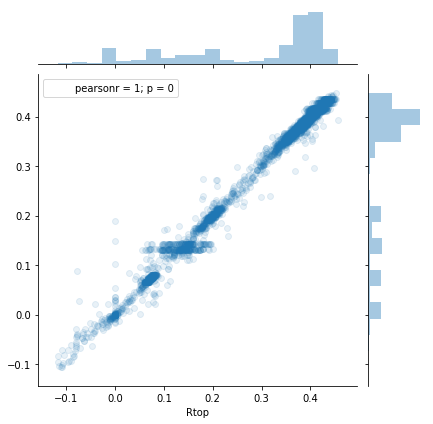

In [14]:
sns.jointplot(x=y,y=yfit,alpha=.1)

In [15]:
from sklearn import datasets, linear_model
from sklearn.model_selection import *
from sklearn.metrics.scorer import make_scorer


In [16]:
cross_validate(rf, Xv, y,scoring='r2')

/usr/local/lib/python2.7/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


{'fit_time': array([12.14322901,  4.43517303, 13.35963607]),
 'score_time': array([0.02453089, 0.02836895, 0.02632689]),
 'test_score': array([0.65776201, 0.18114012, 0.75835595]),
 'train_score': array([0.98856802, 0.99163541, 0.99502525])}

In [17]:
cvpred = cross_val_predict(rf, Xv, y, cv=3)

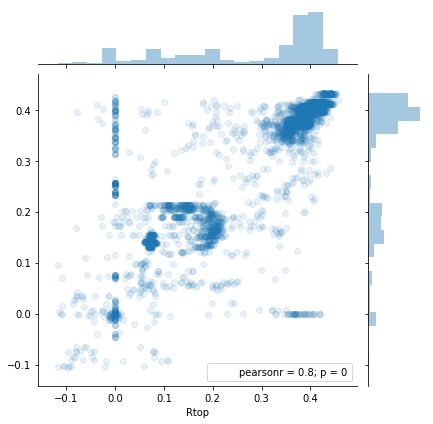

In [18]:
sns.jointplot(x=y,y=cvpred,alpha=.1)

In [19]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [10,20,50,100,200,500]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [20]:
rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [21]:
grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

In [22]:
grid

{'max_depth': [10, 20, 30, 40, 50, None],
 'n_estimators': [10, 20, 50, 100, 200, 500]}

In [23]:
from sklearn.model_selection import GridSearchCV

rf_grid = GridSearchCV(estimator = rf, param_grid=grid,  scoring='r2', cv = 3, verbose=2,  n_jobs = -1)

In [24]:
rf_grid.fit(Xv,y)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] n_estimators=10, max_depth=10 ...................................
[CV] n_estimators=10, max_depth=10 ...................................
[CV] n_estimators=10, max_depth=10 ...................................
[CV] n_estimators=20, max_depth=10 ...................................
[CV] n_estimators=20, max_depth=10 ...................................
[CV] n_estimators=20, max_depth=10 ...................................
[CV] n_estimators=50, max_depth=10 ...................................
[CV] n_estimators=50, max_depth=10 ...................................
[CV] n_estimators=50, max_depth=10 ...................................
[CV] n_estimators=100, max_depth=10 ..................................
[CV] n_estimators=100, max_depth=10 ..................................
[CV] n_estimators=100, max_depth=10 ..................................
[CV] n_estimators=200, max_depth=10 ..................................
[CV] n_estimato

[CV] n_estimators=500, max_depth=40 ..................................
[CV] ................... n_estimators=100, max_depth=30, total=   5.7s
[CV] n_estimators=500, max_depth=40 ..................................
[CV] .................... n_estimators=50, max_depth=40, total=   3.2s
[CV] n_estimators=500, max_depth=40 ..................................
[CV] .................... n_estimators=50, max_depth=40, total=   3.5s
[CV] n_estimators=10, max_depth=50 ...................................
[CV] ................... n_estimators=500, max_depth=10, total=   8.8s
[CV] n_estimators=10, max_depth=50 ...................................
[CV] ................... n_estimators=200, max_depth=20, total=   8.7s
[CV] n_estimators=10, max_depth=50 ...................................
[CV] .................... n_estimators=50, max_depth=40, total=   3.7s
[CV] n_estimators=20, max_depth=50 ...................................
[CV] ................... n_estimators=500, max_depth=10, total=   9.3s
[CV] n

[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  1.4min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [10, 20, 50, 100, 200, 500], 'max_depth': [10, 20, 30, 40, 50, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=2)

In [20]:
cvres = pd.DataFrame(rf_grid.cv_results_)

NameError: name 'rf_grid' is not defined

In [26]:
cvres

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.196159,0.004778,0.504222,0.920180,10,10,"{u'n_estimators': 10, u'max_depth': 10}",36,0.496932,0.910339,0.312819,0.969422,0.702921,0.880780,0.057948,0.000288,0.159320,0.036851
1,0.406629,0.006557,0.508101,0.922314,10,20,"{u'n_estimators': 20, u'max_depth': 10}",35,0.494053,0.911507,0.330114,0.972858,0.700147,0.882577,0.101734,0.000184,0.151371,0.037641
2,1.050223,0.013812,0.515906,0.922235,10,50,"{u'n_estimators': 50, u'max_depth': 10}",34,0.507327,0.912869,0.343242,0.972807,0.697158,0.881028,0.240942,0.000543,0.144593,0.038050
3,2.118504,0.027929,0.523848,0.923038,10,100,"{u'n_estimators': 100, u'max_depth': 10}",31,0.504394,0.913847,0.369556,0.973952,0.697609,0.881317,0.507562,0.003025,0.134614,0.038372
4,4.293842,0.048076,0.521079,0.923230,10,200,"{u'n_estimators': 200, u'max_depth': 10}",32,0.494764,0.914186,0.370403,0.973877,0.698093,0.881627,0.877385,0.001779,0.135049,0.038200
5,10.677947,0.114402,0.517631,0.923685,10,500,"{u'n_estimators': 500, u'max_depth': 10}",33,0.485166,0.914376,0.369936,0.974331,0.697816,0.882349,2.505646,0.002304,0.135794,0.038124
6,0.377041,0.004568,0.588812,0.983211,20,10,"{u'n_estimators': 10, u'max_depth': 20}",28,0.701887,0.979298,0.316139,0.990755,0.748314,0.979581,0.032797,0.000107,0.193698,0.005336
7,0.749846,0.007211,0.594421,0.983967,20,20,"{u'n_estimators': 20, u'max_depth': 20}",22,0.694355,0.979511,0.340759,0.991821,0.748065,0.980568,0.124779,0.000363,0.180664,0.005571
8,1.868501,0.014803,0.593961,0.984198,20,50,"{u'n_estimators': 50, u'max_depth': 20}",25,0.674948,0.979188,0.350431,0.992113,0.756435,0.981292,0.229115,0.001500,0.175350,0.005662
9,3.561664,0.027764,0.594146,0.984236,20,100,"{u'n_estimators': 100, u'max_depth': 20}",24,0.664143,0.979335,0.360526,0.992151,0.757708,0.981222,0.492003,0.000926,0.169519,0.005649


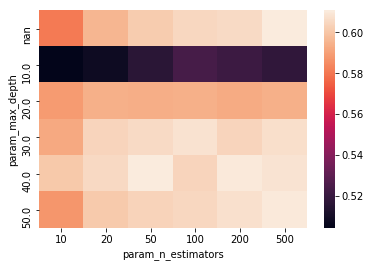

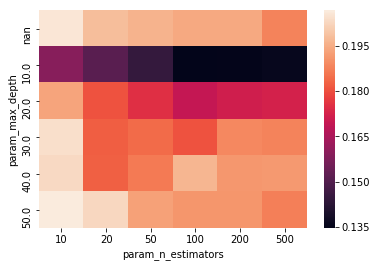

In [27]:
d = cvres.pivot("param_max_depth","param_n_estimators","mean_test_score")
sns.heatmap(d)
plt.figure()
sns.heatmap(cvres.pivot("param_max_depth","param_n_estimators","std_test_score"))

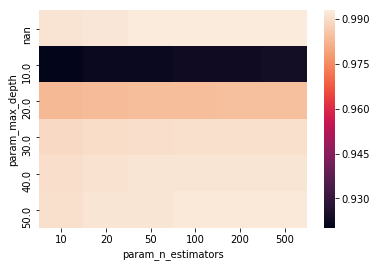

In [28]:
sns.heatmap(cvres.pivot("param_max_depth","param_n_estimators","mean_train_score"))

In [21]:
rf = RandomForestRegressor(n_estimators=20)

In [22]:
cvpred = cross_val_predict(rf, Xv, y, cv=3)

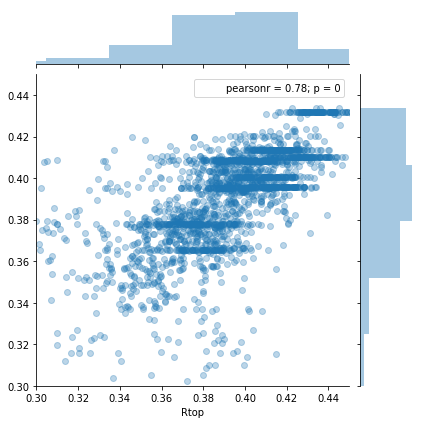

In [23]:
sns.jointplot(y,cvpred,alpha=.3,xlim=(.3,.45),ylim=(.3,.45))

In [24]:
yfit = rf.fit(Xv,y)

In [25]:
tot = 1
for (k,v) in makemodel.getoptions().iteritems():
    if isinstance(v,makemodel.Range):
        tot *= 9
    else:
        tot *= len(v)

In [26]:
'%g' % tot

'2.05457e+44'

In [27]:
import deap
from deap import *

In [28]:
defaults = dictvec.transform(makemodel.getdefaults())
rf.predict(defaults)

array([0.37781492])

In [29]:
modeldefaults = makemodel.getdefaults()
def cleanparams(p):
    '''standardize params that do not matter'''
    for i in xrange(1,6):
        if p['conv%d_width'%i] == 0:
            for suffix in ['func', 'init', 'norm', 'size', 'stride', 'width']:
                name = 'conv%d_%s'%(i,suffix)
                p[name] = modeldefaults[name]
        if p['pool%d_size'%i] == 0:
            name = 'pool%d_type'%i
            p[name] = modeldefaults[name]
            
    if p['fc_pose_hidden'] == 0:
        p['fc_pose_func'] = modeldefaults['fc_pose_func']
        p['fc_pose_hidden2'] = modeldefaults['fc_pose_hidden2']
        p['fc_pose_func2'] = modeldefaults['fc_pose_func2']
        p['fc_pose_init'] = modeldefaults['fc_pose_init']
    elif p['fc_pose_hidden2'] == 0:
        p['fc_pose_hidden2'] = modeldefaults['fc_pose_hidden2']
        p['fc_pose_func2'] = modeldefaults['fc_pose_func2']
        
    if p['fc_affinity_hidden'] == 0:
        p['fc_affinity_func'] = modeldefaults['fc_affinity_func']
        p['fc_affinity_hidden2'] = modeldefaults['fc_affinity_hidden2']
        p['fc_affinity_func2'] = modeldefaults['fc_affinity_func2']
        p['fc_affinity_init'] = modeldefaults['fc_affinity_init']
    elif p['fc_affinity_hidden2'] == 0:
        p['fc_affinity_hidden2'] = modeldefaults['fc_affinity_hidden2']
        p['fc_affinity_func2'] = modeldefaults['fc_affinity_func2']        
        
    return p

In [30]:
def randParam(param, choices):
    '''randomly select a choice for param'''
    if isinstance(choices, makemodel.Range): #discretize
        choices = np.linspace(choices.min,choices.max, 9)
    return np.asscalar(np.random.choice(choices))

def randomIndividual():
    ret = dict()
    options = makemodel.getoptions()
    for (param,choices) in options.iteritems():
        ret[param] = randParam(param, choices)
    
    return cleanparams(ret)

In [31]:
def evaluateIndividual(ind):
    x = dictvec.transform(ind)
    return [rf.predict(x)[0]]

In [32]:
Xv = dictvec.fit_transform(map(cleanparams,X.to_dict(orient='records')))

In [33]:
rf.fit(Xv,y)
yfit = rf.predict(Xv)

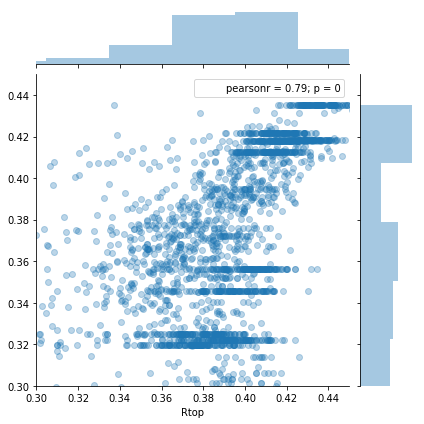

In [34]:
cvpred = cross_val_predict(rf, Xv, y, cv=3)
sns.jointplot(y,cvpred,alpha=.3,xlim=(.3,.45),ylim=(.3,.45))

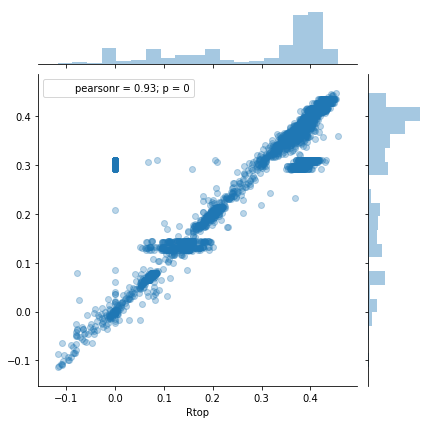

In [35]:
sns.jointplot(y,yfit,alpha=.3)

In [36]:
evaluateIndividual(randomIndividual())

[0.2080152646895317]

In [37]:
def mutateIndividual(ind, indpb=0.05):
    '''for each param, with prob indpb randomly sample another choice'''
    options = makemodel.getoptions()
    for (param,choices) in options.iteritems():
        if np.random.rand() < indpb:
            ind[param] = randParam(param, choices)
    return (ind,)

def crossover(ind1, ind2, indpdb=0.5):
    '''swap choices with probability indpb'''
    options = makemodel.getoptions()
    for (param,choices) in options.iteritems():
        if np.random.rand() < indpdb:
            tmp = ind1[param]
            ind1[param] = ind2[param]
            ind2[param] = tmp
    return (ind1,ind2)    

In [38]:
from deap import base, creator, gp, tools
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", dict, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, randomIndividual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mutate",mutateIndividual)
toolbox.register("mate",crossover)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluateIndividual)


In [39]:
import multiprocessing

pool = multiprocessing.Pool()
toolbox.register("map", pool.map)

In [40]:
randpop = toolbox.population(n=300)
hof = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [41]:
initpop = [ creator.Individual(cleanparams(x)) for x in  X.to_dict('records')]

In [42]:
from deap import algorithms
pop, log = algorithms.eaSimple(toolbox.clone(randpop), toolbox, cxpb=0.5, mutpb=0.2, ngen=500, 
                                   stats=stats, halloffame=hof, verbose=True)

gen	nevals	avg     	std      	min       	max     
0  	300   	0.125692	0.0862782	-0.0658345	0.382094
1  	183   	0.193744	0.0815559	0.000900693	0.382094
2  	186   	0.262406	0.0766599	-0.00898516	0.382094
3  	184   	0.32215 	0.0536855	0.0565018  	0.382094
4  	178   	0.351853	0.035638 	0.075722   	0.384736
5  	162   	0.364633	0.0260688	0.143312   	0.386628
6  	168   	0.369501	0.0350143	0.107469   	0.386628
7  	187   	0.379879	0.0175138	0.113041   	0.386628
8  	155   	0.381875	0.0164147	0.221928   	0.388027
9  	176   	0.380617	0.0258379	0.189351   	0.388027
10 	196   	0.385224	0.0147142	0.182124   	0.388027
11 	171   	0.383983	0.0190065	0.185887   	0.388027
12 	178   	0.379098	0.037816 	0.105764   	0.388027
13 	167   	0.380646	0.0337444	0.0839966  	0.388027
14 	185   	0.384068	0.0254017	0.13826    	0.388027
15 	148   	0.385934	0.0157514	0.240663   	0.388027
16 	174   	0.38243 	0.0332081	0.051005   	0.388027
17 	185   	0.383034	0.0253588	0.205972   	0.388027
18 	180   	0.385544	0.0251225	0.0

160	192   	0.38495 	0.0231427 	0.132464   	0.388027
161	187   	0.38373 	0.0244916 	0.13826    	0.388027
162	180   	0.385614	0.0197072 	0.136198   	0.388027
163	195   	0.383513	0.0243055 	0.18276    	0.388027
164	180   	0.385469	0.0198585 	0.105764   	0.388027
165	200   	0.382612	0.0316779 	0.0739959  	0.388027
166	170   	0.382881	0.0307445 	0.0997641  	0.388027
167	180   	0.383924	0.0219571 	0.137004   	0.388027
168	168   	0.38441 	0.0199374 	0.222742   	0.388027
169	202   	0.386567	0.0114625 	0.277016   	0.388027
170	188   	0.385016	0.0226145 	0.142955   	0.388027
171	181   	0.380498	0.0344918 	0.0752516  	0.388027
172	190   	0.384305	0.0252459 	0.115491   	0.388027
173	188   	0.382424	0.0297474 	0.114052   	0.388027
174	179   	0.382406	0.0286751 	0.124468   	0.388027
175	189   	0.384626	0.0244823 	0.105423   	0.388027
176	177   	0.38291 	0.0274354 	0.139047   	0.388027
177	183   	0.385349	0.01998   	0.130041   	0.388027
178	178   	0.384808	0.0192006 	0.188702   	0.388027
179	167   	0

319	166   	0.385384	0.0191932 	0.167652   	0.388027
320	172   	0.385812	0.0215115 	0.117137   	0.388027
321	180   	0.383543	0.0291864 	0.136198   	0.388027
322	171   	0.383625	0.0284696 	0.127041   	0.388027
323	163   	0.384154	0.0202428 	0.221229   	0.388027
324	169   	0.385023	0.0219565 	0.137004   	0.388027
325	175   	0.382276	0.0328041 	0.0643503  	0.388027
326	178   	0.382989	0.0282873 	0.105764   	0.388027
327	181   	0.383983	0.0270096 	0.137004   	0.388027
328	175   	0.384582	0.0209711 	0.167652   	0.388027
329	174   	0.386177	0.0138066 	0.22033    	0.388027
330	164   	0.38618 	0.0165362 	0.142955   	0.388027
331	167   	0.382902	0.0301611 	0.0920691  	0.388027
332	181   	0.383191	0.0303545 	0.0731897  	0.388027
333	172   	0.382579	0.0279484 	0.104792   	0.388027
334	185   	0.38151 	0.0353429 	0.107131   	0.388027
335	177   	0.381479	0.0319154 	0.138421   	0.388027
336	189   	0.38371 	0.0249941 	0.136198   	0.388027
337	193   	0.38489 	0.0213976 	0.18276    	0.388027
338	173   	0

480	186   	0.384917	0.020657  	0.189285   	0.388027
481	184   	0.380627	0.0379035 	0.0995044  	0.388027
482	174   	0.382321	0.0326893 	0.109669   	0.388027
483	194   	0.384668	0.0202078 	0.22315    	0.388027
484	193   	0.383323	0.0268971 	0.0982308  	0.388027
485	155   	0.385461	0.0162397 	0.232193   	0.388027
486	179   	0.383713	0.0268168 	0.117137   	0.388027
487	173   	0.38595 	0.0134049 	0.229636   	0.388027
488	166   	0.382883	0.0320794 	0.0995044  	0.388027
489	174   	0.385305	0.0214294 	0.117137   	0.388027
490	165   	0.381419	0.0356942 	0.0578141  	0.388027
491	165   	0.384588	0.0256965 	0.086743   	0.388027
492	166   	0.385142	0.0228862 	0.117137   	0.388027
493	204   	0.383545	0.0273915 	0.117137   	0.388027
494	190   	0.383691	0.0265885 	0.0997641  	0.388027
495	172   	0.382189	0.0332988 	0.117137   	0.388027
496	186   	0.385547	0.0184003 	0.219641   	0.388027
497	178   	0.382573	0.0323336 	0.104986   	0.388027
498	168   	0.382951	0.0315729 	0.117137   	0.388027
499	171   	0

In [50]:
hof2 = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
pop2, log = algorithms.eaMuPlusLambda(toolbox.clone(randpop), toolbox, mu=300, lambda_=300, cxpb=0.5, mutpb=0.2, ngen=500, 
                                   stats=stats, halloffame=hof2, verbose=True)

gen	nevals	avg     	std      	min       	max     
0  	300   	0.117062	0.0865216	-0.0967767	0.385691
1  	217   	0.190001	0.0687066	0.0124255 	0.385691
2  	208   	0.248002	0.0563308	0.106956  	0.387033
3  	214   	0.286248	0.0514506	0.149389  	0.387033
4  	206   	0.332004	0.0425736	0.217472  	0.387033
5  	193   	0.364065	0.0284417	0.273538  	0.387033
6  	211   	0.382841	0.00995757	0.32659   	0.387033
7  	198   	0.386784	0.000899152	0.376748  	0.387033
8  	219   	0.387016	0.000235537	0.383169  	0.387033
9  	215   	0.387033	5.55112e-17	0.387033  	0.387033
10 	215   	0.387033	5.55112e-17	0.387033  	0.387033
11 	224   	0.387033	5.55112e-17	0.387033  	0.387033
12 	199   	0.387033	5.55112e-17	0.387033  	0.387033
13 	205   	0.387033	5.55112e-17	0.387033  	0.387033
14 	216   	0.387033	5.55112e-17	0.387033  	0.387033
15 	203   	0.387033	5.55112e-17	0.387033  	0.387033
16 	214   	0.387033	5.55112e-17	0.387033  	0.387033
17 	199   	0.387033	5.55112e-17	0.387033  	0.387033
18 	210   	0.387033	5.55112

158	205   	0.387033	5.55112e-17	0.387033  	0.387033
159	206   	0.387033	5.55112e-17	0.387033  	0.387033
160	203   	0.387033	5.55112e-17	0.387033  	0.387033
161	198   	0.387033	5.55112e-17	0.387033  	0.387033
162	232   	0.387033	5.55112e-17	0.387033  	0.387033
163	202   	0.387033	5.55112e-17	0.387033  	0.387033
164	191   	0.387033	5.55112e-17	0.387033  	0.387033
165	216   	0.387033	5.55112e-17	0.387033  	0.387033
166	218   	0.387033	5.55112e-17	0.387033  	0.387033
167	196   	0.387033	5.55112e-17	0.387033  	0.387033
168	206   	0.387033	5.55112e-17	0.387033  	0.387033
169	214   	0.387033	5.55112e-17	0.387033  	0.387033
170	218   	0.387033	5.55112e-17	0.387033  	0.387033
171	208   	0.387033	5.55112e-17	0.387033  	0.387033
172	218   	0.387033	5.55112e-17	0.387033  	0.387033
173	217   	0.387033	5.55112e-17	0.387033  	0.387033
174	204   	0.387033	5.55112e-17	0.387033  	0.387033
175	217   	0.387033	5.55112e-17	0.387033  	0.387033
176	207   	0.387033	5.55112e-17	0.387033  	0.387033
177	223   	0

317	199   	0.387033	5.55112e-17	0.387033  	0.387033
318	206   	0.387033	5.55112e-17	0.387033  	0.387033
319	195   	0.387033	5.55112e-17	0.387033  	0.387033
320	197   	0.387033	5.55112e-17	0.387033  	0.387033
321	199   	0.387033	5.55112e-17	0.387033  	0.387033
322	209   	0.387033	5.55112e-17	0.387033  	0.387033
323	205   	0.387033	5.55112e-17	0.387033  	0.387033
324	203   	0.387033	5.55112e-17	0.387033  	0.387033
325	217   	0.387033	5.55112e-17	0.387033  	0.387033
326	226   	0.387033	5.55112e-17	0.387033  	0.387033
327	209   	0.387033	5.55112e-17	0.387033  	0.387033
328	206   	0.387033	5.55112e-17	0.387033  	0.387033
329	224   	0.387033	5.55112e-17	0.387033  	0.387033
330	197   	0.387033	5.55112e-17	0.387033  	0.387033
331	208   	0.387033	5.55112e-17	0.387033  	0.387033
332	219   	0.387033	5.55112e-17	0.387033  	0.387033
333	203   	0.387033	5.55112e-17	0.387033  	0.387033
334	206   	0.387033	5.55112e-17	0.387033  	0.387033
335	200   	0.387033	5.55112e-17	0.387033  	0.387033
336	199   	0

476	208   	0.387033	5.55112e-17	0.387033  	0.387033
477	209   	0.387033	5.55112e-17	0.387033  	0.387033
478	224   	0.387033	5.55112e-17	0.387033  	0.387033
479	214   	0.387033	5.55112e-17	0.387033  	0.387033
480	217   	0.387033	5.55112e-17	0.387033  	0.387033
481	199   	0.387033	5.55112e-17	0.387033  	0.387033
482	203   	0.387033	5.55112e-17	0.387033  	0.387033
483	208   	0.387033	5.55112e-17	0.387033  	0.387033
484	214   	0.387033	5.55112e-17	0.387033  	0.387033
485	212   	0.387033	5.55112e-17	0.387033  	0.387033
486	214   	0.387033	5.55112e-17	0.387033  	0.387033
487	211   	0.387033	5.55112e-17	0.387033  	0.387033
488	206   	0.387033	5.55112e-17	0.387033  	0.387033
489	219   	0.387033	5.55112e-17	0.387033  	0.387033
490	203   	0.387033	5.55112e-17	0.387033  	0.387033
491	202   	0.387033	5.55112e-17	0.387033  	0.387033
492	211   	0.387033	5.55112e-17	0.387033  	0.387033
493	222   	0.387033	5.55112e-17	0.387033  	0.387033
494	197   	0.387033	5.55112e-17	0.387033  	0.387033
495	221   	0

In [106]:
hof3 = tools.HallOfFame(10)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
pop3, log = algorithms.eaMuPlusLambda(toolbox.clone(randpop+initpop), toolbox, mu=300, lambda_=300, cxpb=0.5, mutpb=0.2, ngen=500, 
                                   stats=stats, halloffame=hof3, verbose=True)

gen	nevals	avg     	std     	min      	max    
0  	3885  	0.268636	0.139677	-0.104469	0.43835
1  	206   	0.375477	0.0659599	0.0749015	0.43835
2  	201   	0.413691	0.0193256	0.337176 	0.434914
3  	198   	0.427223	0.00898158	0.372444 	0.434914
4  	206   	0.432788	0.00390736	0.41105  	0.434914
5  	210   	0.434769	0.000959089	0.427952 	0.435391
6  	209   	0.434919	4.75056e-05	0.434914 	0.435391
7  	221   	0.43494 	0.000193896	0.434914 	0.436771
8  	200   	0.435027	0.000419591	0.434914 	0.436771
9  	211   	0.435281	0.00071803 	0.434914 	0.436771
10 	218   	0.43567 	0.000869872	0.434914 	0.436771
11 	199   	0.436357	0.000736157	0.434914 	0.437462
12 	199   	0.436773	0.000231465	0.434914 	0.437462
13 	218   	0.436838	0.000163846	0.436771 	0.437462
14 	211   	0.43692 	0.000228591	0.436771 	0.43794 
15 	216   	0.437081	0.000251408	0.436771 	0.43794 
16 	203   	0.437316	0.00022871 	0.436771 	0.43794 
17 	217   	0.437527	0.000491331	0.430339 	0.43794 
18 	210   	0.437802	0.00022298 	0.437249 	0.43

160	211   	0.438484	1.11022e-16	0.438484 	0.438484
161	209   	0.438484	1.11022e-16	0.438484 	0.438484
162	216   	0.438484	1.11022e-16	0.438484 	0.438484
163	199   	0.438484	1.11022e-16	0.438484 	0.438484
164	214   	0.438484	1.11022e-16	0.438484 	0.438484
165	208   	0.438484	1.11022e-16	0.438484 	0.438484
166	206   	0.438484	1.11022e-16	0.438484 	0.438484
167	219   	0.438484	1.11022e-16	0.438484 	0.438484
168	204   	0.438484	1.11022e-16	0.438484 	0.438484
169	201   	0.438484	1.11022e-16	0.438484 	0.438484
170	214   	0.438484	1.11022e-16	0.438484 	0.438484
171	217   	0.438484	1.11022e-16	0.438484 	0.438484
172	215   	0.437759	0.0125237  	0.221204 	0.438484
173	205   	0.438484	1.11022e-16	0.438484 	0.438484
174	214   	0.438484	1.11022e-16	0.438484 	0.438484
175	215   	0.438484	1.11022e-16	0.438484 	0.438484
176	212   	0.438484	1.11022e-16	0.438484 	0.438484
177	205   	0.438484	1.11022e-16	0.438484 	0.438484
178	226   	0.438484	1.11022e-16	0.438484 	0.438484
179	211   	0.438484	1.11022e-16

322	197   	0.438484	1.11022e-16	0.438484 	0.438484
323	214   	0.438484	1.11022e-16	0.438484 	0.438484
324	195   	0.438484	1.11022e-16	0.438484 	0.438484
325	218   	0.438484	1.11022e-16	0.438484 	0.438484
326	221   	0.438484	1.11022e-16	0.438484 	0.438484
327	210   	0.438484	1.11022e-16	0.438484 	0.438484
328	204   	0.438484	1.11022e-16	0.438484 	0.438484
329	197   	0.438484	1.11022e-16	0.438484 	0.438484
330	209   	0.438484	1.11022e-16	0.438484 	0.438484
331	215   	0.438471	0.000214997	0.434753 	0.438484
332	195   	0.438484	1.11022e-16	0.438484 	0.438484
333	207   	0.438484	1.11022e-16	0.438484 	0.438484
334	212   	0.438484	1.11022e-16	0.438484 	0.438484
335	219   	0.438484	1.11022e-16	0.438484 	0.438484
336	204   	0.438484	1.11022e-16	0.438484 	0.438484
337	215   	0.438452	0.000390339	0.433344 	0.438484
338	216   	0.438484	1.11022e-16	0.438484 	0.438484
339	214   	0.438484	1.11022e-16	0.438484 	0.438484
340	208   	0.438484	1.11022e-16	0.438484 	0.438484
341	215   	0.438484	1.11022e-16

485	202   	0.438484	1.11022e-16	0.438484 	0.438484
486	204   	0.438484	1.11022e-16	0.438484 	0.438484
487	205   	0.438484	1.11022e-16	0.438484 	0.438484
488	213   	0.438484	1.11022e-16	0.438484 	0.438484
489	221   	0.438484	1.11022e-16	0.438484 	0.438484
490	216   	0.438481	3.98341e-05	0.437792 	0.438484
491	222   	0.438484	1.11022e-16	0.438484 	0.438484
492	208   	0.438462	0.000364386	0.432162 	0.438484
493	187   	0.438484	1.11022e-16	0.438484 	0.438484
494	225   	0.438484	1.11022e-16	0.438484 	0.438484
495	208   	0.438484	1.11022e-16	0.438484 	0.438484
496	217   	0.438484	1.11022e-16	0.438484 	0.438484
497	213   	0.438484	1.11022e-16	0.438484 	0.438484
498	191   	0.438484	1.11022e-16	0.438484 	0.438484
499	218   	0.438484	1.11022e-16	0.438484 	0.438484
500	214   	0.438484	1.11022e-16	0.438484 	0.438484


In [43]:
def runGA(pop):
    '''run GA with early stopping if not improving'''
    hof = tools.HallOfFame(10)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    best = 0
    pop = toolbox.clone(pop)
    for i in xrange(40):
        pop, log = algorithms.eaMuPlusLambda(pop, toolbox, mu=300, lambda_=300, cxpb=0.5, mutpb=0.2, ngen=25, 
                                       stats=stats, halloffame=hof, verbose=True)
        newmax = log[-1]['max']
        if best == newmax:
            break
        best = newmax
    return pop

In [44]:
pop = runGA(initpop+randpop)

gen	nevals	avg     	std     	min      	max    
0  	3965  	0.270707	0.140356	-0.113348	0.44694
1  	204   	0.378137	0.0601037	0.127002 	0.44441
2  	216   	0.412261	0.020045 	0.26819  	0.44441
3  	216   	0.425565	0.0103653	0.390974 	0.44441
4  	224   	0.432211	0.00647664	0.415433 	0.44441
5  	214   	0.436541	0.0036709 	0.42785  	0.44441
6  	205   	0.44    	0.00337743	0.435104 	0.44694
7  	202   	0.442945	0.00239223	0.435104 	0.44694
8  	219   	0.444452	0.00117933	0.435104 	0.44694
9  	232   	0.445205	0.00105935	0.443207 	0.44694
10 	203   	0.445986	0.00107466	0.44441  	0.44694
11 	209   	0.44672 	0.000621305	0.44441  	0.447691
12 	211   	0.446966	0.000178694	0.445437 	0.447691
13 	230   	0.447013	0.000221713	0.44694  	0.447691
14 	216   	0.447115	0.000317336	0.44694  	0.447691
15 	218   	0.447326	0.000375011	0.44694  	0.447691
16 	220   	0.447598	0.000246709	0.44694  	0.447691
17 	203   	0.447691	5.55112e-17	0.447691 	0.447691
18 	208   	0.447691	5.55112e-17	0.447691 	0.447691
19 	211   	

In [109]:
[x.fitness for x in pop]

[deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.FitnessMax((0.4384835577313811,)),
 deap.creator.Fitnes

In [130]:
import deepdiff
import pprint
pp = pprint.PrettyPrinter()

In [125]:
best = data.sort_values(by='Rtop',ascending=False).to_dict('records')[0]
bestrop = best['Rtop']
for p in notparams:
    del best[p]
best = deap.creator.Individual(cleanparams(best))

In [132]:
cleanparams(pop[0])

{'balanced': 1,
 'base_lr_exp': -1.875,
 'conv1_func': 'ReLU',
 'conv1_init': 'uniform',
 'conv1_norm': 'none',
 'conv1_size': 3,
 'conv1_stride': 1,
 'conv1_width': 32,
 'conv2_func': 'ReLU',
 'conv2_init': 'xavier',
 'conv2_norm': 'none',
 'conv2_size': 3,
 'conv2_stride': 1,
 'conv2_width': 64,
 'conv3_func': 'ReLU',
 'conv3_init': 'xavier',
 'conv3_norm': 'none',
 'conv3_size': 3,
 'conv3_stride': 1,
 'conv3_width': 128,
 'conv4_func': 'ReLU',
 'conv4_init': 'xavier',
 'conv4_norm': 'none',
 'conv4_size': 3,
 'conv4_stride': 1,
 'conv4_width': 0,
 'conv5_func': 'ReLU',
 'conv5_init': 'xavier',
 'conv5_norm': 'none',
 'conv5_size': 3,
 'conv5_stride': 1,
 'conv5_width': 0,
 'fc_affinity_func': 'ReLU',
 'fc_affinity_func2': 'ReLU',
 'fc_affinity_hidden': 0,
 'fc_affinity_hidden2': 0,
 'fc_affinity_init': 'xavier',
 'fc_pose_func': 'ReLU',
 'fc_pose_func2': 'ReLU',
 'fc_pose_hidden': 0,
 'fc_pose_hidden2': 0,
 'fc_pose_init': 'xavier',
 'jitter': 0.0,
 'loss_delta': 4.0,
 'loss_gap': 

In [133]:
for p in pop[:10]:
    pp.pprint(deepdiff.DeepDiff(best,cleanparams(p),verbose_level=0))

{'values_changed': {"root['base_lr_exp']": {'new_value': -1.875,
                                            'old_value': -2.0},
                    "root['conv1_init']": {'new_value': 'uniform',
                                           'old_value': 'xavier'},
                    "root['loss_penalty']": {'new_value': 3.75,
                                             'old_value': 0.0},
                    "root['pool5_size']": {'new_value': 8, 'old_value': 0},
                    "root['weight_decay_exp']": {'new_value': -7.5,
                                                 'old_value': -3.0}}}
{'values_changed': {"root['base_lr_exp']": {'new_value': -1.875,
                                            'old_value': -2.0},
                    "root['conv1_init']": {'new_value': 'uniform',
                                           'old_value': 'xavier'},
                    "root['loss_delta']": {'new_value': 3.0,
                                           'old_value': 4.0},
         

In [57]:
[h.fitness for h in hof2]

[deap.creator.FitnessMax((0.3880651730511736,)),
 deap.creator.FitnessMax((0.3870333565446721,)),
 deap.creator.FitnessMax((0.3870333565446721,)),
 deap.creator.FitnessMax((0.3870333565446721,)),
 deap.creator.FitnessMax((0.3870333565446721,)),
 deap.creator.FitnessMax((0.3870333565446721,)),
 deap.creator.FitnessMax((0.3870333565446721,)),
 deap.creator.FitnessMax((0.3870333565446721,)),
 deap.creator.FitnessMax((0.3870333565446721,)),
 deap.creator.FitnessMax((0.3870333565446721,))]

In [134]:
rf.feature_importances_

array([2.20780973e-04, 1.70722657e-01, 2.64407473e-05, 6.43765203e-04,
       8.88708501e-03, 1.09740684e-05, 2.70650510e-05, 2.30343619e-06,
       8.33993099e-06, 6.64863603e-04, 2.32089817e-06, 9.94115329e-05,
       1.01259295e-05, 8.00239187e-04, 3.03788056e-05, 1.55247262e-04,
       5.06185707e-04, 9.95754784e-04, 1.67438542e-03, 5.05102927e-03,
       6.46959434e-06, 7.09764468e-04, 1.06361381e-05, 9.39010978e-06,
       1.31304257e-05, 4.98109030e-06, 4.40222499e-06, 1.21523220e-05,
       1.08683546e-05, 1.62358341e-05, 7.83145027e-06, 7.31458827e-04,
       1.74404034e-05, 8.01202168e-04, 1.39043024e-03, 1.04404653e-02,
       5.59743971e-04, 5.22371112e-03, 1.86453305e-05, 9.44093591e-04,
       1.20216253e-04, 4.07793808e-05, 1.32525683e-04, 1.08343239e-05,
       6.86509586e-06, 3.18454238e-04, 7.63510006e-06, 8.27222651e-05,
       2.85092866e-06, 9.63261195e-04, 1.35404908e-04, 2.04892818e-04,
       3.05024350e-04, 1.07332440e-03, 3.09806795e-03, 3.33169414e-03,
      

In [60]:
importances[indices]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Feature ranking:


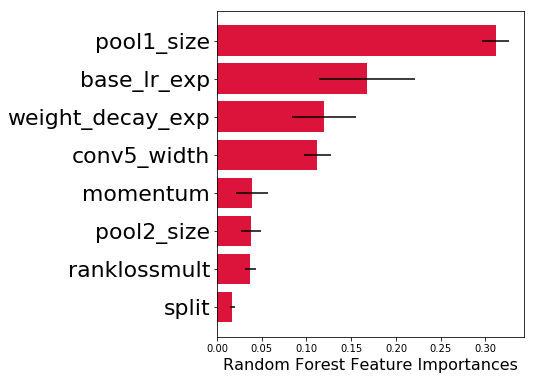

In [82]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[-8:]

# Print the feature ranking
print("Feature ranking:")

num = Xv.shape[1]
#for f in range(num):
#    print("%s\t (%f)" % (dictvec.feature_names_[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(5.5,6))
plt.xlabel("Random Forest Feature Importances",fontsize=16)
plt.barh(range(len(indices)), importances[indices],
       color="crimson", xerr=std[indices], align="center")
plt.yticks(range(len(indices)), np.array(dictvec.feature_names_)[indices])
#plt.ylim(-.5,30.5)
#plt.tick_params(labelsize=14)
plt.tick_params(axis='y',labelsize=22)
plt.savefig('improt.pdf',bbox_inches='tight')

In [61]:
seen = set(map(frozendict.frozendict,initpop))

In [62]:
for p in pop:
    print frozendict.frozendict(p) in seen, p.fitness

False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
True (0.435140260538471,)
False (0.435140260538471,)
True (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
True (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
True (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False (0.435140260538471,)
False

In [63]:
p.fitness

deap.creator.FitnessMax((0.435140260538471,))

In [64]:
initpop[0].fitness

deap.creator.FitnessMax(())

In [65]:
frozendict.frozendict(initpop[0])
                                

<frozendict {'conv4_norm': 'none', 'loss_pseudohuber': 1, 'jitter': 0.0, 'conv2_width': 64, 'conv5_norm': 'none', 'conv3_size': 3, 'balanced': 1, 'pool5_type': 'MAX', 'stratify_affinity_step': 1, 'conv5_width': 0, 'conv2_size': 3, 'loss_gap': 0.0, 'conv2_stride': 1, 'conv3_init': 'xavier', 'fc_affinity_func': 'ReLU', 'momentum': 0.9, 'conv3_width': 128, 'fc_affinity_init': 'xavier', 'conv5_size': 3, 'loss_delta': 4.0, 'conv5_func': 'ReLU', 'pool5_size': 0, 'solver': 'SGD', 'conv5_stride': 1, 'fc_pose_hidden2': 0, 'conv4_size': 3, 'stratify_affinity': 0, 'fc_affinity_hidden': 0, 'conv4_init': 'xavier', 'ranklossneg': 0, 'pool4_size': 0, 'conv1_stride': 1, 'split': 0, 'conv4_func': 'ReLU', 'pool4_type': 'MAX', 'conv1_norm': 'none', 'pool2_type': 'MAX', 'loss_penalty': 0.0, 'fc_pose_init': 'xavier', 'conv1_size': 3, 'conv3_norm': 'none', 'fc_pose_hidden': 0, 'conv4_width': 0, 'conv1_width': 32, 'conv2_init': 'xavier', 'pool1_type': 'MAX', 'pool2_size': 2, 'conv4_stride': 1, 'pool1_size': 

In [66]:
len(filter(lambda p: frozendict.frozendict(p) not in seen, pop))

282

In [67]:
p.items()

[('conv4_norm', 'none'),
 ('loss_pseudohuber', 1),
 ('jitter', 0.0),
 ('conv2_width', 64),
 ('pool4_size', 0),
 ('conv1_stride', 1),
 ('conv5_norm', 'none'),
 ('conv3_size', 3),
 ('pool4_type', 'MAX'),
 ('balanced', 1),
 ('ranklossneg', 0),
 ('stratify_affinity_step', 1),
 ('base_lr_exp', -2.0),
 ('conv1_norm', 'none'),
 ('conv5_width', 0),
 ('conv2_size', 3),
 ('conv3_stride', 1),
 ('pool2_type', 'AVE'),
 ('loss_penalty', 0.0),
 ('fc_pose_init', 'xavier'),
 ('conv1_size', 3),
 ('conv3_norm', 'none'),
 ('fc_pose_hidden', 0),
 ('loss_gap', 0.0),
 ('split', 2),
 ('conv2_init', 'xavier'),
 ('pool1_type', 'MAX'),
 ('conv4_width', 0),
 ('pool2_size', 0),
 ('conv2_stride', 1),
 ('conv3_init', 'xavier'),
 ('fc_affinity_func', 'ReLU'),
 ('momentum', 0.9),
 ('conv3_width', 128),
 ('fc_affinity_init', 'xavier'),
 ('conv5_size', 3),
 ('conv4_stride', 3),
 ('pool1_size', 0),
 ('loss_delta', 4.0),
 ('pool3_size', 8),
 ('weight_decay_exp', -3.0),
 ('conv1_func', 'ReLU'),
 ('conv2_norm', 'none'),
 ('

In [68]:
initpop[0].fitness

deap.creator.FitnessMax(())

In [69]:
evals = pool.map(toolbox.evaluate, initpop)

In [70]:
top = sorted([l[0] for l in evals],reverse=True)[0]

In [71]:
top

0.435140260538471

In [72]:
Xv.shape

(3565, 144)

In [73]:
dictvec.feature_names_

['balanced',
 'base_lr_exp',
 'conv1_func=ELU',
 'conv1_func=ReLU',
 'conv1_func=Sigmoid',
 'conv1_func=TanH',
 'conv1_func=leaky',
 'conv1_init=gaussian',
 'conv1_init=msra',
 'conv1_init=positive_unitball',
 'conv1_init=radial',
 'conv1_init=radial.5',
 'conv1_init=uniform',
 'conv1_init=xavier',
 'conv1_norm=BatchNorm',
 'conv1_norm=LRN',
 'conv1_norm=none',
 'conv1_size',
 'conv1_stride',
 'conv1_width',
 'conv2_func=ELU',
 'conv2_func=ReLU',
 'conv2_func=Sigmoid',
 'conv2_func=TanH',
 'conv2_func=leaky',
 'conv2_init=gaussian',
 'conv2_init=msra',
 'conv2_init=positive_unitball',
 'conv2_init=radial',
 'conv2_init=radial.5',
 'conv2_init=uniform',
 'conv2_init=xavier',
 'conv2_norm=BatchNorm',
 'conv2_norm=LRN',
 'conv2_norm=none',
 'conv2_size',
 'conv2_stride',
 'conv2_width',
 'conv3_func=ELU',
 'conv3_func=ReLU',
 'conv3_func=Sigmoid',
 'conv3_func=TanH',
 'conv3_func=leaky',
 'conv3_init=gaussian',
 'conv3_init=msra',
 'conv3_init=positive_unitball',
 'conv3_init=radial',
 'c

In [74]:
dictvec.inverse_transform(dict(pop[0]))

TypeError: float() argument must be a string or a number

In [ ]:
pop[0]